In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, 
                                     BatchNormalization, Dropout)
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

#from google.colab import files

#%matplotlib inline


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Нейронная сеть по определению расположенности пациентов к сердечным заболеваниям.
Набор данных имеет 11 параметров и 1 целвой столбец.
Для улчшения работы и повышения точности производим парамтризацию параметров и приведение в категорию целевых значений.
Строим полносвязную сеть с колбэками понижения скорости обучения и сохранения модели с лучшими показателями точности. Получаем точность на тестовой выборке 92 %.
Проверяем работу на записи выборки X_test[111] и данных вымышленного пациента.

In [4]:
# Загружаем датасет и выводим случайные 5 сторок
heart_df = pd.read_csv('e:/diploma/heart_diploma.csv')
heart_df.sample(5)


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
643,46,0,4,138,243,0,2,152,1,0.0,2,0
417,63,1,4,140,260,0,1,112,1,3.0,2,1
374,59,1,4,135,0,0,0,115,1,1.0,2,1
1178,55,0,2,132,342,0,0,166,0,1.2,1,0
1099,41,1,3,130,214,0,2,168,0,2.0,2,0


In [5]:
# Новое расположение колонок для удобства
new_columns = [1, 0, 3, 7, 6, 10, 4, 5, 2, 8, 9, 11]
heart_df = heart_df[heart_df.columns[new_columns]]
heart_df.sample(5)


,sex,age,resting bp s,max heart rate,resting ecg,ST slope,cholesterol,fasting blood sugar,chest pain type,exercise angina,oldpeak,target
821,1,55,160,145,2,2,289,0,4,1,0.8,1
1142,0,42,120,173,0,2,209,0,3,0,0.0,0
216,0,30,170,170,1,1,237,0,1,0,0.0,0
364,1,56,120,148,1,2,0,0,4,0,0.0,1
392,1,70,115,92,1,2,0,0,4,1,0.0,1


In [6]:
heart_df['ST slope'].unique()

array([1, 2, 3, 0], dtype=int64)

In [7]:
# информация о датасете по столбцам
heart_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sex                  1190 non-null   int64  
 1   age                  1190 non-null   int64  
 2   resting bp s         1190 non-null   int64  
 3   max heart rate       1190 non-null   int64  
 4   resting ecg          1190 non-null   int64  
 5   ST slope             1190 non-null   int64  
 6   cholesterol          1190 non-null   int64  
 7   fasting blood sugar  1190 non-null   int64  
 8   chest pain type      1190 non-null   int64  
 9   exercise angina      1190 non-null   int64  
 10  oldpeak              1190 non-null   float64
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [8]:
# выводим все признаки с параметрами
heart_df.describe()


,sex,age,resting bp s,max heart rate,resting ecg,ST slope,cholesterol,fasting blood sugar,chest pain type,exercise angina,oldpeak,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,0.763866,53.720168,132.153782,139.732773,0.698319,1.624370,210.363866,0.213445,3.232773,0.387395,0.944286,0.528571
std,0.424884,9.358203,18.368823,25.517636,0.870359,0.610459,101.420489,0.409912,0.935480,0.487360,1.067675,0.499393
min,0.000000,28.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,47.000000,120.000000,121.000000,0.000000,1.000000,188.000000,0.000000,3.000000,0.000000,0.000000,0.000000
50%,1.000000,54.000000,130.000000,140.500000,0.000000,2.000000,229.000000,0.000000,4.000000,0.000000,0.650000,1.000000
75%,1.000000,60.000000,140.000000,160.000000,2.000000,2.000000,269.750000,0.000000,4.000000,1.000000,1.600000,1.000000
max,1.000000,77.000000,200.000000,202.000000,2.000000,3.000000,603.000000,1.000000,4.000000,1.000000,6.200000,1.000000


In [9]:
# создаем data для дальнешего создания X, y
data = heart_df.values
data


array([[  1. ,  40. , 140. , ...,   0. ,   0. ,   0. ],
       [  0. ,  49. , 160. , ...,   0. ,   1. ,   1. ],
       [  1. ,  37. , 130. , ...,   0. ,   0. ,   0. ],
       ...,
       [  1. ,  57. , 130. , ...,   1. ,   1.2,   1. ],
       [  0. ,  57. , 130. , ...,   0. ,   0. ,   1. ],
       [  1. ,  38. , 138. , ...,   0. ,   0. ,   0. ]])

In [10]:
X = data[:,0:11].astype(float)   # Присваиваем тип данных - float(с плавающей точкой) данным в столбцах 0 по 11
y = data[:,11].astype(int)       # Присваиваем тип данных - int столбцу target


In [11]:
# Создаем Обучающую и тестовую выборки и смотрим их размеры
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=17)
print(f' X_train: {X_train.shape} \n X_test: {X_test.shape} \n y_train: {y_train.shape} \n y_test: {y_test.shape}')


 X_train: (952, 11) 
 X_test: (238, 11) 
 y_train: (952,) 
 y_test: (238,)


In [12]:
# смотрим образцы X_train[1], X_test[1] 
X_train[1], X_test[1]


(array([  0. ,  60. , 150. , 157. ,   2. ,   2. , 258. ,   0. ,   4. ,
          0. ,   2.6]),
 array([  0. ,  51. , 130. , 142. ,   0. ,   2. , 305. ,   0. ,   4. ,
          1. ,   1.2]))

In [13]:
X_train = normalize(X_train)
X_test = normalize(X_test)
X_train[1], X_test[1]


(array([0.        , 0.17515448, 0.4378862 , 0.45832089, 0.00583848,
        0.00583848, 0.75316426, 0.        , 0.01167697, 0.        ,
        0.00759003]),
 array([0.        , 0.13999559, 0.35685151, 0.38979165, 0.        ,
        0.00549002, 0.83722854, 0.        , 0.01098005, 0.00274501,
        0.00329401]))

In [14]:
# переводим y_train, y_test в категорикал
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_train.shape, y_test.shape


((952, 2), (238, 2))

In [15]:
# смотрим образцы y_train, y_test
y_train[1], y_test[1]


(array([0., 1.], dtype=float32), array([0., 1.], dtype=float32))

In [47]:
inp_ecg = np.array(heart_df['resting ecg'])
#inp_ecg = inp_ecg.reshape(-1, 1)
#inp_ecg = normalize(inp_ecg)


In [48]:
inp_ecg

array([0, 0, 1, ..., 0, 2, 0], dtype=int64)

In [18]:
X_train.shape[1]

11

In [49]:
# модель с полносвязными слоями (при экспериментах показала лучшие результаты)
model = Sequential([
                    BatchNormalization(input_shape=(X_train.shape[1], )),
                    Dense(128, activation='relu'),
                    Dropout(0.2),
                    BatchNormalization(),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    BatchNormalization(),
                    Dense(128, activation='relu'),
                    Dropout(0.3),
                    BatchNormalization(),
                    Dense(128, activation='relu'),
                    Dropout(0.2),
                    BatchNormalization(),
                    Flatten(),
                    Dense(2, activation='sigmoid')   # linear 
                  ])


TypeError: 'numpy.int64' object is not iterable

In [42]:
# Компилируем модель начальная скорость обучения устанавливается на 1е-2 для лучшей работы callback
model.compile(optimizer=Adam(learning_rate=1e-2), loss='categorical_crossentropy',  metrics=['accuracy'])


In [43]:
# струтра модели
model.summary()
#plot_model(model, dpi=70, show_shapes=True)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_35 (Batc (None, 11, 0)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 11, 128)           128       
_________________________________________________________________
dropout_28 (Dropout)         (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 11, 128)           512       
_________________________________________________________________
dense_36 (Dense)             (None, 11, 128)           16512     
_________________________________________________________________
dropout_29 (Dropout)         (None, 11, 128)           0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 11, 128)          

In [44]:
# Callback понижения скорости обучения
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.99, patience=20, min_lr=0.000001)

# Сallback сохранения мовели с лучшим результатом
save_best_res = [ModelCheckpoint('diploma_heart.hdf5', monitor='val_accuracy', save_best_only=True)]


In [45]:
# Обучаем модель
history = model.fit(X_train, y_train,  batch_size=512, epochs=1000, validation_data=(X_test, y_test), callbacks=[reduce_lr, save_best_res], verbose=1)


Epoch 1/1000


ValueError: in user code:

    C:\Programs\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Programs\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Programs\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Programs\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Programs\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Programs\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Programs\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:795 train_step
        y_pred = self(x, training=True)
    C:\Programs\Python39\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Programs\Python39\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:215 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 11)


In [24]:
# максимальная точность  и ошибка на обучающей и проверочной выборе
print(f'Максимальная точность обучающей выборки: {max(history.history["accuracy"])} \
\nМинимальная ошибка на обучающей выборе: {min(history.history["loss"])} \
\nМаксимальная точность проверочной выборки: {max(history.history["val_accuracy"])} \
\nМинимальная ошибка на проверочной выборе: {min(history.history["val_loss"])}')


Максимальная точность обучающей выборки: 0.9968487620353699 
Минимальная ошибка на обучающей выборе: 0.01441285666078329 
Максимальная точность проверочной выборки: 0.9327731132507324 
Минимальная ошибка на проверочной выборе: 0.4945751428604126


In [25]:
#model.save('diploma_heart.h5')

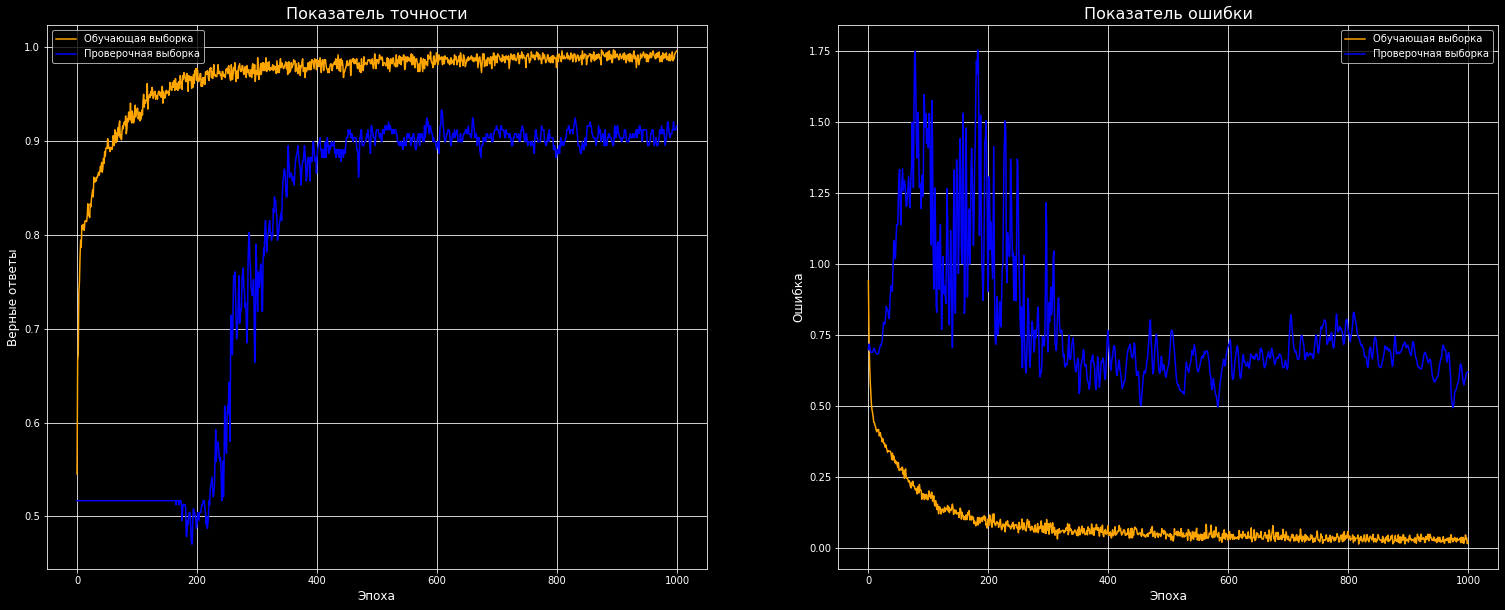

In [26]:
# Выводим графики точности и ошибки
plt.figure(figsize=(26, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='orange', label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], color='blue', label='Проверочная выборка')
plt.title('Показатель точности', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Верные ответы', fontsize=12)
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='orange', label='Обучающая выборка')
plt.plot(history.history['val_loss'], color='blue', label='Проверочная выборка')
plt.title('Показатель ошибки', fontsize=16)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Ошибка', fontsize=12)
plt.legend()
plt.grid()

plt.show()


In [27]:
# Загружаем сохраненуую модель
save_model = load_model('diploma_heart.hdf5')

In [28]:
# Проверяем на тестовой выборке
prediction = save_model.predict(X_test)
print(f'Расположенность к сердечным заболеваниям: {100*prediction[122][1]:.2f} %')


Расположенность к сердечным заболеваниям: 7.14 %


In [29]:
# Подаем данные вымышленного пациента и проверяем
proba = np.array([[1, 47, 160, 174, 0, 1, 263, 0, 2, 0, 0.0]])
proba = normalize(proba)
test_proba = save_model.predict(proba)
print(f'Расположенность к сердечным заболеваниям: {100*test_proba[0][1]:.2f} %')


Расположенность к сердечным заболеваниям: 2.98 %
